In [61]:
# Setup & Imports

# Import Python standard libraries and data tools
import os
import sys
import time
from datetime import datetime

# Import third‑party libraries for data handling, plotting, and mapping
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import Element
from folium.plugins import TimestampedGeoJson
from requests.exceptions import HTTPError
from dotenv import load_dotenv

# Configure project root and add src/ directory to Python path
PROJECT_ROOT = os.path.abspath("..")
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

# Import AQI fetching function
from fetch_aqi import fetch_daily_aqi

# Load API key from .env file
load_dotenv(os.path.join(PROJECT_ROOT, ".env"))


True

In [62]:
#  City & Date Definitions

# Define list of 5 US cities with ZIP codes and labels
cities = [
    ("30301", "Atlanta, GA"),
    ("59101", "Billings, MT"),
    ("02108", "Boston, MA"),
    ("60601", "Chicago, IL"),
    ("80202", "Denver, CO"),
    ("50309", "Des Moines, IA"),
    ("77001", "Houston, TX"),
    ("64101", "Kansas City, MO"),
    ("55401", "Minneapolis, MN"),
    ("10001", "New York, NY"),
    ("19104", "Philadelphia, PA"),
    ("85001", "Phoenix, AZ"),
    ("94103", "San Francisco, CA"),
    ("98101", "Seattle, WA"),
    ("68102", "Omaha, NE"), 
]

# Define the date window
start_date = "2025-07-21"
end_date   = "2025-07-28"

# Generate the list of dates
dates = pd.date_range(start_date, end_date)

# Display summary of planned API calls
print(f"Preparing to fetch AQI for {len(cities)} cities over {len(dates)} days → {len(cities) * len(dates)} calls")


Preparing to fetch AQI for 15 cities over 8 days → 120 calls


In [63]:
# Cell 3: Fetch Raw AQI Data
# Initialize list for collecting API responses
records = []

# Loop through each city and date, handle HTTP errors, and throttle requests
for zip_code, city in cities:
    for dt in dates:
        try:
            observations = fetch_daily_aqi(zip_code, dt.strftime("%Y-%m-%d"))
            for obs in observations:
                records.append({
                    "date":      obs["DateObserved"],
                    "city":      city,
                    "state":     obs["StateCode"],
                    "latitude":  obs["Latitude"],
                    "longitude": obs["Longitude"],
                    "AQI":       obs["AQI"],
                    "category":  obs["Category"]["Name"],
                    "parameter": obs["ParameterName"]
                })
        except HTTPError as e:
            status = e.response.status_code
            print(f"[{status}] skipped {city} on {dt.date()}")
        # Pause briefly to respect API rate limits
        time.sleep(0.5)

# Convert to DataFrame and save raw CSV
df_full = pd.DataFrame(records)
raw_path = os.path.join(PROJECT_ROOT, "data/raw/aqi_raw.csv")
os.makedirs(os.path.dirname(raw_path), exist_ok=True)
df_full.to_csv(raw_path, index=False)
print(f"Fetched {len(df_full)} rows → saved to data/raw/aqi_raw.csv")

# Preview first 10 row of raw data
df_full.head(10)


Fetched 302 rows → saved to data/raw/aqi_raw.csv


,date,city,state,latitude,longitude,AQI,category,parameter
0,2025-07-21,"Atlanta, GA",GA,33.65,-84.43,28,Good,OZONE
1,2025-07-21,"Atlanta, GA",GA,33.65,-84.43,53,Moderate,PM2.5
2,2025-07-21,"Atlanta, GA",GA,33.65,-84.43,27,Good,PM10
3,2025-07-22,"Atlanta, GA",GA,33.65,-84.43,67,Moderate,OZONE
4,2025-07-22,"Atlanta, GA",GA,33.65,-84.43,46,Good,PM2.5
5,2025-07-22,"Atlanta, GA",GA,33.65,-84.43,20,Good,PM10
6,2025-07-23,"Atlanta, GA",GA,33.65,-84.43,41,Good,OZONE
7,2025-07-23,"Atlanta, GA",GA,33.65,-84.43,44,Good,PM2.5
8,2025-07-23,"Atlanta, GA",GA,33.65,-84.43,15,Good,PM10
9,2025-07-24,"Atlanta, GA",GA,33.65,-84.43,41,Good,OZONE


In [64]:
# Load & Inspect Raw Data
# Load the raw AQI data saved in data/raw/aqi_raw.csv
df_raw = pd.read_csv(
    "../data/raw/aqi_raw.csv",
    parse_dates=["date"]   # convert 'date' column to datetime
)

# Display the first few rows
df_raw.head(10)

# Display shape and info
print("Shape:", df_raw.shape)
df_raw.info()

# Show counts of each AQI category
print("\nAQI category counts:")
print(df_raw["category"].value_counts())


Shape: (302, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       302 non-null    datetime64[ns]
 1   city       302 non-null    object        
 2   state      302 non-null    object        
 3   latitude   302 non-null    float64       
 4   longitude  302 non-null    float64       
 5   AQI        302 non-null    int64         
 6   category   302 non-null    object        
 7   parameter  302 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 19.0+ KB

AQI category counts:
category
Good                              212
Moderate                           86
Unhealthy for Sensitive Groups      3
Unhealthy                           1
Name: count, dtype: int64


In [65]:
# Aggregate to Daily Max AQI

# Identify the index of the max‑AQI reading for each (date, city)
idx = df_raw.groupby(["date", "city"])["AQI"].idxmax()

# Select those rows and sort by city and date
df_daily = (
    df_raw
      .loc[idx]
      .sort_values(["city", "date"])
      .reset_index(drop=True)
)

# Save the aggregated results
processed_path = os.path.join(PROJECT_ROOT, "data/processed/aqi_daily.csv")
os.makedirs(os.path.dirname(processed_path), exist_ok=True)
df_daily.to_csv(processed_path, index=False)
print(f"Saved {len(df_daily)} daily max‑AQI rows → {processed_path}")

# Preview the first 10 rows of the daily max‑AQI data
df_daily.head(10)


Saved 118 daily max‑AQI rows → d:\WebDevProjects\Data Analyst\aqi-explorer\data/processed/aqi_daily.csv


,date,city,state,latitude,longitude,AQI,category,parameter
0,2025-07-21,"Atlanta, GA",GA,33.6500,-84.4300,53,Moderate,PM2.5
1,2025-07-22,"Atlanta, GA",GA,33.6500,-84.4300,67,Moderate,OZONE
2,2025-07-23,"Atlanta, GA",GA,33.6500,-84.4300,44,Good,PM2.5
3,2025-07-24,"Atlanta, GA",GA,33.6500,-84.4300,48,Good,PM2.5
4,2025-07-25,"Atlanta, GA",GA,33.6500,-84.4300,46,Good,OZONE
5,2025-07-26,"Atlanta, GA",GA,33.6500,-84.4300,31,Good,OZONE
6,2025-07-27,"Atlanta, GA",GA,33.6500,-84.4300,36,Good,OZONE
7,2025-07-28,"Atlanta, GA",GA,33.6500,-84.4300,44,Good,OZONE
8,2025-07-21,"Billings, MT",MT,45.7822,-108.5115,24,Good,PM2.5
9,2025-07-22,"Billings, MT",MT,45.7822,-108.5115,55,Moderate,PM2.5


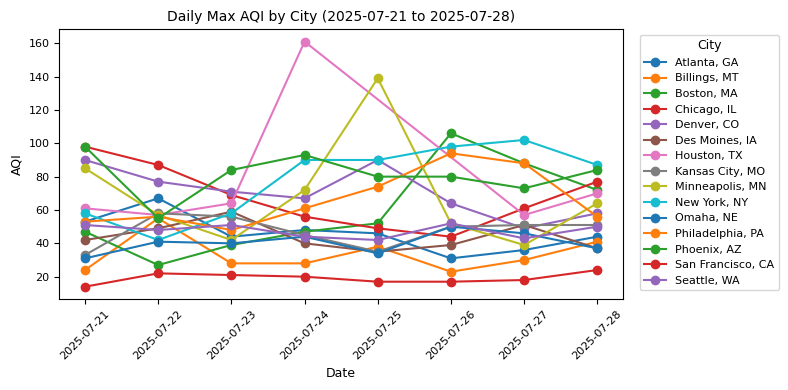

In [66]:
#Time‑Series Plot of Daily Max AQI

# Ensure README_images directory exists at project root
readme_img_dir = os.path.join(PROJECT_ROOT, "README_images")
os.makedirs(readme_img_dir, exist_ok=True)

# Plot AQI trends over time for each city with a more compact size
fig, ax = plt.subplots(figsize=(8, 4))  # reduced from (12, 6) to (8, 4)
for city, grp in df_daily.groupby("city"):
    ax.plot(grp["date"], grp["AQI"], marker='o', label=city)

ax.set_title(f"Daily Max AQI by City ({start_date} to {end_date})", fontsize=10)
ax.set_xlabel("Date", fontsize=9)
ax.set_ylabel("AQI", fontsize=9)
ax.legend(title="City", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, title_fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

# Save the figure to README_images in the project root
output_path = os.path.join(readme_img_dir, "time_series.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


In [67]:
# Time‑Slider Map – No Extra White Space & In‑Map Legend

import os
from folium import Element
from folium.plugins import TimestampedGeoJson

# Ensure output folder exists
map_dir = os.path.join(PROJECT_ROOT, "README_images")
os.makedirs(map_dir, exist_ok=True)

# Build GeoJSON features
features = []
for _, row in df_daily.iterrows():
    features.append({
        "type": "Feature",
        "properties": {
            "time":    row["date"].strftime("%Y-%m-%dT%H:%M:%S"),
            "popup":   f"{row['city']}<br>AQI: {row['AQI']} ({row['category']})",
            "icon":    "circle",
            "style": {
                "radius":      6,
                "color":       cat_colors[row["category"]],
                "fillColor":   cat_colors[row["category"]],
                "fillOpacity": 0.7
            }
        },
        "geometry": {
            "type":        "Point",
            "coordinates": [row["longitude"], row["latitude"]]
        }
    })
geojson = {"type": "FeatureCollection", "features": features}

# Compute map bounds and center
min_lat, max_lat = df_daily["latitude"].min(), df_daily["latitude"].max()
min_lon, max_lon = df_daily["longitude"].min(), df_daily["longitude"].max()
center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]
bounds = [[min_lat, min_lon], [max_lat, max_lon]]

# Create the map at 100%×100% of its container
m_ts = folium.Map(
    location=center,
    zoom_start=4,       # will be overridden by fit_bounds
    width="100%",
    height="100%"
)

# Add the timestamped layer
TimestampedGeoJson(
    data=geojson,
    transition_time=200,
    period="P1D",
    add_last_point=True,
    auto_play=False,
    loop=False,
    loop_button=True,
    date_options="YYYY-MM-DD",
    time_slider_drag_update=True
).add_to(m_ts)

# Fit to bounds so all markers fill the view
m_ts.fit_bounds(bounds)

# Inject global CSS into <head> to remove page margin/overflow
header_css = """
<style>
  html, body { margin:0; padding:0; height:100%; overflow:hidden; }
  .leaflet-container { position: relative !important; }
</style>
"""
m_ts.get_root().header.add_child(Element(header_css))

# Inject an in‑map legend, absolutely positioned above the slider
legend_html = """
<div style="
    position: absolute;
    bottom: 60px;    /* moved up from 10px */
    left: 10px;
    background: rgba(255, 255, 255, 0.9);
    border: 1px solid #777;
    padding: 6px;
    font-size: 12px;
    line-height: 1.3;
    z-index: 1000;
">
  <strong>AQI Categories</strong><br>
  <span style="color:green;">●</span>&nbsp;Good (0–50)<br>
  <span style="color:yellow;">●</span>&nbsp;Moderate (51–100)<br>
  <span style="color:orange;">●</span>&nbsp;Unhealthy SG (101–150)<br>
  <span style="color:red;">●</span>&nbsp;Unhealthy (151–200)<br>
  <span style="color:purple;">●</span>&nbsp;Very Unhealthy (201–300)<br>
  <span style="color:maroon;">●</span>&nbsp;Hazardous (301+)
</div>
"""
m_ts.get_root().html.add_child(Element(legend_html))

# Wrap map in a flex container of fixed aspect ratio
#    (this will appear in the saved HTML too)
wrapper = """
<style>
  #map { width:100vw; height:60vh; }
  .folium-map { width:100%; height:100%; }
</style>
<div id="map"></div>
<script>
  // Move the Leaflet-generated map into our #map div
  document.querySelector('#map').appendChild(document.querySelector('.folium-map'));
</script>
"""
m_ts.get_root().html.add_child(Element(wrapper))

# Save and display
map_file = os.path.join(map_dir, "aqi_time_slider_map.html")
m_ts.save(map_file)
print(f"Saved clean time-slider map to {map_file}")

m_ts  # render in notebook


Saved clean time-slider map to d:\WebDevProjects\Data Analyst\aqi-explorer\README_images\aqi_time_slider_map.html
